In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

2024-06-20 06:08:09.952724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 06:08:09.952815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 06:08:10.078155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! wget http://images.cocodataset.org/zips/test2014.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-20 06:08:20--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.147.108, 52.217.114.177, 52.217.225.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.147.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: 'test2014.zip'

test2014.zip        100%[===================>]   6.20G  23.8MB/s    in 4m 31s  

2024-06-20 06:12:51 (23.5 MB/s) - 'test2014.zip' saved [6660437059/6660437059]



In [ ]:
!unzip test2014.zip

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.002, pepper_prob=0.002):
     noisy_image = np.copy(image)
     total_pixels = image.shape[0] * image.shape[1]
    
     num_salt = np.ceil(salt_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 1

     num_pepper = np.ceil(pepper_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 0

     return noisy_image

def add_poisson_noise(image):
    vals = len(np.unique(image))
    vals = 3 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals)
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image*0.5

def add_gaussian_noise(image, mean=0, std=0.07):
    image = image.astype(np.float32)
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

In [6]:
class NoiseImageDataset(Dataset):
    
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target_size = (128,128)
        image = cv2.resize(image,target_size,interpolation=cv2.INTER_LINEAR)
        
        image = image.astype(np.float32) / 255.0
        
        noise_image = add_salt_and_pepper_noise(image)
        noise_image = add_poisson_noise(noise_image)
        noise_image = add_gaussian_noise(noise_image)
        
        image = torch.tensor(image).permute(2, 0, 1)
        noise_image = torch.tensor(noise_image).permute(2, 0, 1)
        
        return  noise_image.to(device) ,image.to(device)

In [ ]:
image_directory = '/kaggle/working/test2014'
image_paths = glob.glob(os.path.join(image_directory, '*.jpg'))
dataset = NoiseImageDataset(image_paths)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

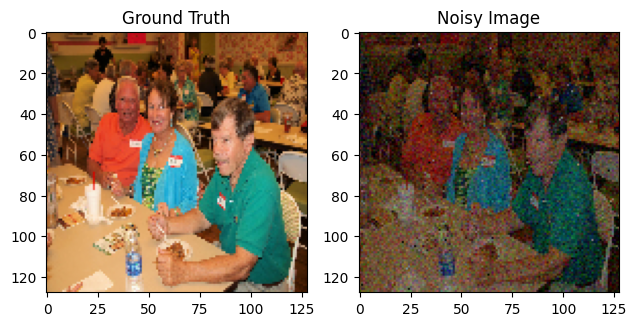

In [16]:
#Visualizing first image of first two batches in dataloader for reference :
for index ,(noise,image) in enumerate(dataloader):
    if index == 0:
        noise = noise[0].squeeze().permute(1, 2, 0).cpu().numpy()
        image = image[0].squeeze().permute(1, 2, 0).cpu().numpy()

        noise = (noise * 255).astype(int)
        image = (image * 255).astype(int)
        
        plt.figure(figsize=(80, 20))
        
        plt.subplot(1,20,2)
        plt.title('Noisy Image')
        plt.imshow(noise, cmap='gray')
        
        plt.subplot(1,20,1)
        plt.title('Ground Truth')
        plt.imshow(image, cmap='gray')

        plt.show()
        
    if index == 1:
        break;

In [63]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(256, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))

        dec3 = self.upconv3(enc3)
        dec3 = self.decoder3(torch.cat([dec3, enc2], dim=1))  # skip connection

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc1], dim=1))  # skip connection

        dec1 = self.upconv1(dec2)
        dec1 = self.conv(dec1)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))  # skip connection

        output = self.final_conv(dec1)
        return output


In [64]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer_ids):
        super(PerceptualLoss, self).__init__()
        vgg19 = models.vgg19(pretrained=True).features.eval()
        self.layer_ids = layer_ids
        self.vgg19 = vgg19
        for param in self.vgg19.parameters():
            param.requires_grad = False 
        self.criterion = nn.MSELoss()

    def forward(self, output, target):
        output_fea = self.get_features(output.float())
        target_fea = self.get_features(target.float())
        
        loss = 0
        for o_f, t_f in zip(output_fea, target_fea):
            loss += self.criterion(o_f, t_f)
        return loss.item()
    
    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg19):
            x = layer(x)
            if i in self.layer_ids:
                features.append(x)
        return features

In [ ]:
layer_ids = [3, 8, 17, 26]
percep_loss = PerceptualLoss(layer_ids).to(device)
net = UNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=(1e-3)/2)
num_epochs = 20

In [46]:
epoch_loss = []
epoch_n = []
psnr_e = []

In [47]:
def psnr(gt_image, pred_images, max_val=1.0):
    mse = torch.mean((gt_image - pred_images) ** 2)
    psnr_val = 10 * torch.log10((max_val ** 2) / mse)
    return psnr_val

In [59]:
for epoch in range(num_epochs):
    net.train()
    
    epoch_loss = 0.0
    psnr_sum = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for image,noise in progress_bar:
        
        image = image.to(device)
        noise = noise.to(device)
        
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            output = net(noise)
            pixel_loss = nn.MSELoss()(output, image)
            p_loss = percep_loss(output, image)
            loss = pixel_loss + 0.01 * p_loss
                
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        psnr_batch = psnr(image, output)
        psnr_sum += psnr_batch

    avg_epoch_loss = epoch_loss/len(dataloader)
    avg_psnr = psnr_sum / len(dataloader)
    
    epoch_loss.append(avg_epoch_loss)
    epoch_n.append(epoch + 1)
    psnr_e.append(avg_psnr)

    if epoch+1 == 15:
        torch.save(net.state_dict(),f"/kaggle/working/15_unet_ploss_vgg19.pth")
    

    print(f"Epoch : {epoch+1} , Loss : {avg_epoch_loss} , PSNR : {avg_psnr}")

torch.save(net.state_dict() , "/kaggle/working/20_unet_ploss_vgg19.pth")


Epoch 1/20:  65%|██████▌   | 1660/2549 [08:40<04:38,  3.19it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 38.12 MiB is free. Process 3698 has 15.86 GiB memory in use. Of the allocated memory 15.14 GiB is allocated by PyTorch, and 429.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF